In [41]:
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.transforms import functional as TF
import random
from tqdm import tqdm

In [28]:
# Load a pretrained DeepLabV3 model
model = torch.hub.load('pytorch/vision:v0.15.2', 'deeplabv3_resnet101', pretrained=True)
model.eval()

Using cache found in C:\Users\William Pearson/.cache\torch\hub\pytorch_vision_v0.15.2


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [29]:
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Masks should be tensors of long type (class labels)
mask_transform = transforms.Compose([
    transforms.PILToTensor(),   # keeps pixel values as-is
    transforms.Lambda(lambda x: x.squeeze().long())
])

def preprocess(image_path):
    image = Image.open(image_path).convert("RGB")
    return input_transform(image).unsqueeze(0)



In [30]:
# Function to visualize output (keep PIL for convenience)
def visualize(output, image_path):
    # read original image for visualization
    original_image = Image.open(image_path).convert("RGB")

    output_predictions = output['out'][0].argmax(0).byte().cpu().numpy()

    palette = np.array([
        [0, 0, 0],        # background
        [128, 0, 0],      # aeroplane
        [0, 128, 0],      # bicycle
        [128, 128, 0],    # bird
        [0, 0, 128],      # boat
        [128, 0, 128],    # bottle
        [0, 128, 128],    # bus
        [128, 128, 128],  # car
        [64, 0, 0],       # cat
        [192, 0, 0],      # chair
        [64, 128, 0],     # cow
        [192, 128, 0],    # diningtable
        [64, 0, 128],     # dog
        [192, 0, 128],    # horse
        [64, 128, 128],   # motorbike
        [192, 128, 128],  # person
        [0, 64, 0],       # potted plant
        [128, 64, 0],     # sheep
        [0, 192, 0],      # sofa
        [128, 192, 0],    # train
        [0, 64, 128],     # tv/monitor
    ])

    r = Image.fromarray(output_predictions).resize(original_image.size)
    r.putpalette(palette.flatten())

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title("Segmented")
    plt.imshow(r)
    plt.axis('off')
    plt.show()

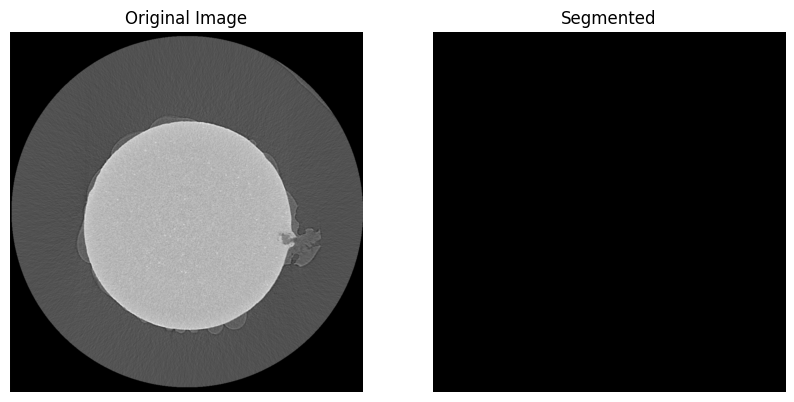

In [31]:
# Main
image_path = 'dataset/images/img_1.png' 
input_tensor = preprocess(image_path)

with torch.no_grad():
    output = model(input_tensor)

visualize(output, image_path)

In [67]:
def delete_all_images(folder_path):
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
    print(f"Deleted all images in {folder_path}")

class SegmentationTransforms:
    def __init__(self, image_size=(256, 256), degrees=15, scale=(0.8, 1.2), shear=10):
        self.image_size = image_size
        self.degrees = degrees
        self.scale = scale
        self.shear = shear

    def __call__(self, image, mask):
        # Horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random affine transform (rotation + translation + scale + shear)
        angle = random.uniform(-self.degrees, self.degrees)
        translations = (0, 0)  # you can add translation if you want
        scale = random.uniform(self.scale[0], self.scale[1])
        shear = random.uniform(-self.shear, self.shear)
        image = TF.affine(image, angle=angle, translate=translations, scale=scale, shear=shear, fill=0)
        mask = TF.affine(mask, angle=angle, translate=translations, scale=scale, shear=shear, fill=0, interpolation=TF.InterpolationMode.NEAREST)

        # Random crop params
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=self.image_size)
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Color jitter only on image
        image = transforms.ColorJitter(0.2, 0.2, 0.2, 0.05)(image)

        # Optional: random Gaussian blur on image only
        if random.random() > 0.7:
            image = TF.gaussian_blur(image, kernel_size=3)

        # Resize both to image_size (just in case)
        image = TF.resize(image, self.image_size)
        mask = TF.resize(mask, self.image_size, interpolation=TF.InterpolationMode.NEAREST)

        return image, mask
    
#directories
input_img_dir = "dataset_original/images"
input_mask_dir = "dataset_original/masks"
output_img_dir = "dataset/images"
output_mask_dir = "dataset/masks"

# Parameters
n_aug_per_image = 500  # How many augmentations per original image

# Instantiate transformer
transform = SegmentationTransforms(image_size=(256, 256))

# List of original image files (excluding already augmented ones)
image_filenames = [f for f in os.listdir(input_img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

#Remove all current audmentations
delete_all_images(output_img_dir)
delete_all_images(output_mask_dir)

count = 1
for img_file in tqdm(image_filenames, desc="Augmenting"):
    base_name = os.path.splitext(img_file)[0]
    img_path = os.path.join(input_img_dir, img_file)
    mask_path = os.path.join(input_mask_dir, base_name + ".png")  # Assuming mask is .png

    # Load image and mask
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    for _ in range(n_aug_per_image):
        aug_img, aug_mask = transform(image.copy(), mask.copy())

        aug_img.save(os.path.join(output_img_dir, f"img_{count}.png"))
        aug_mask.save(os.path.join(output_mask_dir, f"img_{count}.png"))

        count += 1

Deleted all images in dataset/images
Deleted all images in dataset/masks


Augmenting: 100%|██████████| 1/1 [00:13<00:00, 13.38s/it]


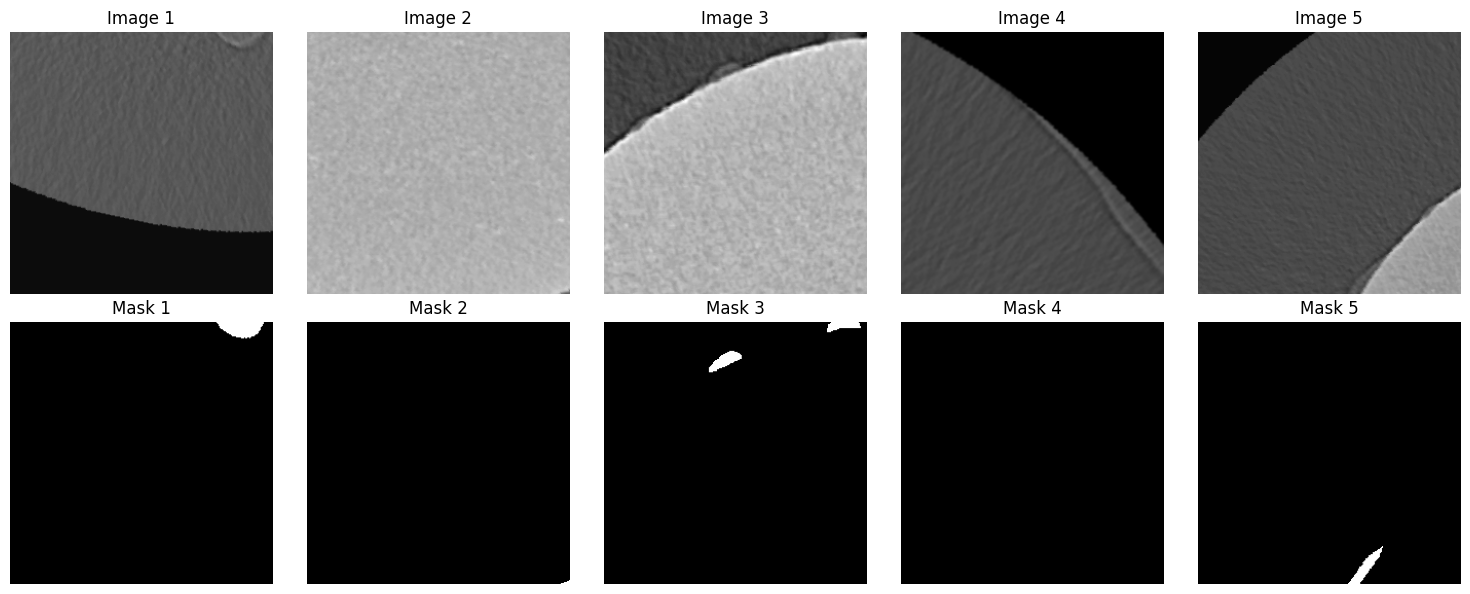

In [69]:
# List of original image files (excluding already augmented ones)
image_filenames = [f for f in os.listdir(output_img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Load the first 5 image-mask pairs
images = [Image.open(os.path.join(output_img_dir, fname)) for fname in image_filenames[:5]]
masks = [Image.open(os.path.join(output_mask_dir, fname)) for fname in image_filenames[:5]]

# Plot
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    axs[0, i].imshow(images[i])
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Image {i+1}")

    axs[1, i].imshow(masks[i], cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title(f"Mask {i+1}")

plt.tight_layout()
plt.show()

In [50]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, img_name)).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [71]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

num_classes = 2  # background + your object

model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_dataset = SegmentationDataset("dataset/images", "dataset/masks", input_transform, mask_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

epochs = 5

model.train()
for epoch in range(epochs):
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        output = model(imgs)['out']
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

torch.save(model, 'segmentation_model_full.pth')

Epoch 1: Loss = 0.1585
Epoch 2: Loss = 0.0835
Epoch 3: Loss = 0.0485
Epoch 4: Loss = 0.0558
Epoch 5: Loss = 0.0596


In [55]:
def visualize_prediction(image_path, prediction):
    image = Image.open(image_path).convert("RGB")

    # Optional: define color palette
    palette = np.array([
        [0, 0, 0],         # class 0: background
        [255, 0, 0],       # class 1: your object (e.g., red)
        # Add more colors if more classes
    ])

    # Create RGB segmentation map
    color_mask = palette[prediction]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Segmentation")
    plt.imshow(color_mask)
    plt.axis('off')

    plt.show()

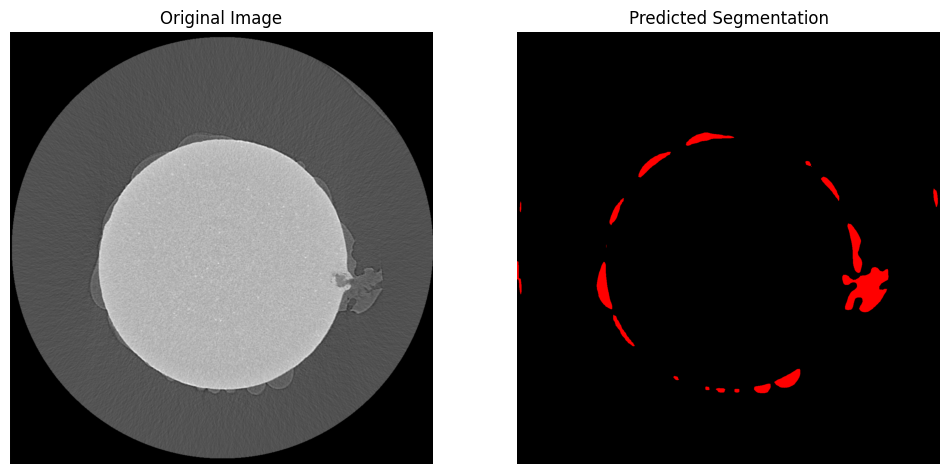

In [73]:
model.eval()

image_path = 'dataset_original/images/img_1.png'
input_tensor = preprocess(image_path).to(device)

with torch.no_grad():
    output = model(input_tensor)['out']
    predicted = output.argmax(1).squeeze(0).cpu().numpy()

visualize_prediction(image_path, predicted)